In [1]:
# @title Download SemEval-2018 Task 1 (Affect in Tweets)
# 1. Install the library
!pip install kagglehub -q

import kagglehub
import pandas as pd
import os

print("Downloading dataset from Kaggle...")

# 2. Download the latest version
path = kagglehub.dataset_download("context/semeval-2018-task-ec")

print(f"Download complete. Path: {path}")

# 3. Find and Load the correct file
target_file = None
for root, dirs, files in os.walk(path):
    for file in files:
        # We look for the training file ending in .txt
        if "train" in file and "En" in file and file.endswith(".txt"):
            target_file = os.path.join(root, file)
            break

if target_file:
    # 4. Load into Pandas
    train_df = pd.read_csv(target_file, sep='\t')

    print(f"Total Samples: {len(train_df)}")
    print("\nSample Tweets:")
    print(train_df[['Tweet', 'anger', 'joy', 'love','pessimism']].head(5))
else:
    print("⚠️ Could not auto-detect the specific training file.")
    print("Here are the files found in the folder:")
    print(os.listdir(path))


100%|██████████| 602k/602k [00:00<00:00, 57.5MB/s]

Extracting files...
Download complete. Path: /root/.cache/kagglehub/datasets/context/semeval-2018-task-ec/versions/1
Total Samples: 6838

Sample Tweets:
                                               Tweet  anger  joy  love  \
0  “Worry is a down payment on a problem you may ...      0    0     0   
1  Whatever you decide to do make sure it makes y...      0    1     1   
2  @Max_Kellerman  it also helps that the majorit...      1    1     0   
3  Accept the challenges so that you can literall...      0    1     0   
4  My roommate: it's okay that we can't spell bec...      1    0     0   

   pessimism  
0          0  
1          0  
2          0  
3          0  
4          0  


## Prepare Dataset for Fine-tuning

In [2]:
emotions = ['anger', 'joy', 'love', 'pessimism']
train_df['labels'] = train_df[emotions].values.tolist()

print("Modified DataFrame head with 'labels' and 'text' columns:")
print(train_df[['Tweet', 'labels'] + emotions].head())

Modified DataFrame head with 'labels' and 'text' columns:
                                               Tweet        labels  anger  \
0  “Worry is a down payment on a problem you may ...  [0, 0, 0, 0]      0   
1  Whatever you decide to do make sure it makes y...  [0, 1, 1, 0]      0   
2  @Max_Kellerman  it also helps that the majorit...  [1, 1, 0, 0]      1   
3  Accept the challenges so that you can literall...  [0, 1, 0, 0]      0   
4  My roommate: it's okay that we can't spell bec...  [1, 0, 0, 0]      1   

   joy  love  pessimism  
0    0     0          0  
1    1     1          0  
2    1     0          0  
3    1     0          0  
4    0     0          0  


## Split Data for Training and Validation

In [3]:
from datasets import Dataset

# Convert the pandas DataFrame to a Hugging Face Dataset
dataset = Dataset.from_pandas(train_df, preserve_index=False)

# Split the dataset into training and validation sets
train_test_split_dataset = dataset.train_test_split(test_size=0.2, seed=42)

# Access the training and validation sets
train_dataset = train_test_split_dataset['train']
val_dataset = train_test_split_dataset['test']

print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print("Sample from training dataset:")
print(train_dataset[0])

Training set size: 5470
Validation set size: 1368
Sample from training dataset:
{'ID': '2017-En-20862', 'Tweet': '@GroundSwellCLE @ClevelandCNBC @KingJames @mavcarter @SpringHillEnt @boughb #revitalize #ClevelandHustles #daunting task, #hustle', 'anger': 0, 'anticipation': 0, 'disgust': 0, 'fear': 0, 'joy': 0, 'love': 0, 'optimism': 0, 'pessimism': 0, 'sadness': 0, 'surprise': 0, 'trust': 0, 'labels': [0, 0, 0, 0]}


## Fine-tune Standard Monolingual Model



In [4]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn import metrics
import numpy as np

print("Necessary libraries imported.")

Necessary libraries imported.


In [5]:
import torch # Import torch for type casting
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding
from sklearn import metrics
import numpy as np

print("Necessary libraries imported.")

model_checkpoint = "distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

def preprocess_function(examples):
    # Tokenize the text
    tokenized_examples = tokenizer(examples["Tweet"], truncation=True)
    # Ensure labels are in the correct format (list of floats/ints for multi-label)
    tokenized_examples["labels"] = examples["labels"]
    return tokenized_examples

# Apply the preprocessing function to both datasets
tokenized_train_dataset = train_dataset.map(preprocess_function, batched=True)
tokenized_val_dataset = val_dataset.map(preprocess_function, batched=True)

# Load the model for sequence classification
# The number of labels is the length of the 'emotions' list
num_labels = len(emotions)
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels, problem_type="multi_label_classification")

# Define a custom DataCollator to ensure labels are float32
class CustomDataCollator(DataCollatorWithPadding):
    def __call__(self, features):
        batch = super().__call__(features)
        # Ensure labels are of type torch.float32 for BCEWithLogitsLoss
        if "labels" in batch:
            batch["labels"] = batch["labels"].to(torch.float32)
        return batch

# Define compute_metrics function
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    # Apply sigmoid to predictions to get probabilities for multi-label
    probabilities = 1 / (1 + np.exp(-predictions))
    # Convert probabilities to binary predictions (threshold 0.5)
    binary_predictions = (probabilities > 0.5).astype(int)

    # Calculate metrics for multi-label classification
    f1_score_micro = metrics.f1_score(labels, binary_predictions, average='micro')
    f1_score_weighted = metrics.f1_score(labels, binary_predictions, average='weighted')
    accuracy = metrics.accuracy_score(labels, binary_predictions)
    precision_micro = metrics.precision_score(labels, binary_predictions, average='micro')
    recall_micro = metrics.recall_score(labels, binary_predictions, average='micro')

    return {
        'f1_micro': f1_score_micro,
        'f1_weighted': f1_score_weighted,
        'accuracy': accuracy,
        'precision_micro': precision_micro,
        'recall_micro': recall_micro,
    }

# Configure training arguments
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    eval_strategy="epoch",
    logging_dir="./logs",
    logging_steps=100,
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_micro",
    greater_is_better=True,
)

# Instantiate the custom data collator
data_collator = CustomDataCollator(tokenizer=tokenizer)

# Instantiate the Trainer, passing the custom data_collator
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# Start training
print("Starting model training...")
trainer.train()
print("Model training complete.")

Necessary libraries imported.


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/5470 [00:00<?, ? examples/s]

Map:   0%|          | 0/1368 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2768606006.py:81: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Starting model training...


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 2


wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: jenniferchristy0507 (jenniferchristy0507-iit-bombay) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,F1 Micro,F1 Weighted,Accuracy,Precision Micro,Recall Micro
1,0.335300,0.323997,0.683814,0.649652,0.565058,0.824599,0.584091
2,0.274700,0.314387,0.702361,0.680424,0.573830,0.791825,0.631061
3,0.235100,0.315107,0.713008,0.697060,0.573099,0.769298,0.664394


Model training complete.


In [6]:
# @title Test
import torch

def predict_emotions(text):
    # 1. Tokenize the text
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(model.device)

    # 2. Get predictions
    with torch.no_grad():
        logits = model(**inputs).logits

    # 3. Convert to percentages (Sigmoid)
    probs = torch.sigmoid(logits).cpu().numpy()[0]

    # 4. Display results above a certain threshold (e.g., 30%)
    print(f"\nTweet: '{text}'")
    print("Detected Mental States:")
    found = False
    for idx, score in enumerate(probs):
        if score > 0.3: # Threshold
            print(f"   - {emotions[idx].capitalize()}: {score:.1%}")
            found = True

    if not found:
        print("   - (Neutral / No strong emotion detected)")

predict_emotions("I am stressed about my exam but happy that I learned so much!")
predict_emotions("This code error is making me lose my mind.")


Tweet: 'I am stressed about my exam but happy that I learned so much!'
Detected Mental States:
   - Joy: 97.5%
   - Love: 66.6%

Tweet: 'This code error is making me lose my mind.'
Detected Mental States:
   - Anger: 64.4%
   - Pessimism: 35.8%


## Fine-tune Multilingual Model



In [7]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

print("Loading multilingual tokenizer and model...")

# 1. Define the model_checkpoint variable
multilingual_model_checkpoint = "bert-base-multilingual-cased"

# 2. Load the tokenizer for the model_checkpoint
multilingual_tokenizer = AutoTokenizer.from_pretrained(multilingual_model_checkpoint)

# 3. Load the model for sequence classification
# The number of labels is the length of the 'emotions' list (from previous steps)
multilingual_model = AutoModelForSequenceClassification.from_pretrained(
    multilingual_model_checkpoint,
    num_labels=len(emotions),
    problem_type="multi_label_classification"
)

print("Multilingual tokenizer and model loaded successfully.")

Loading multilingual tokenizer and model...


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Multilingual tokenizer and model loaded successfully.


In [8]:
print("Tokenizing datasets using multilingual tokenizer...")

def preprocess_function_multilingual(examples):
    # Tokenize the text using the multilingual tokenizer
    tokenized_examples = multilingual_tokenizer(examples["Tweet"], truncation=True)
    # Ensure labels are in the correct format (list of floats/ints for multi-label)
    tokenized_examples["labels"] = examples["labels"]
    return tokenized_examples

# Apply the preprocessing function to both datasets
tokenized_multilingual_train_dataset = train_dataset.map(preprocess_function_multilingual, batched=True)
tokenized_multilingual_val_dataset = val_dataset.map(preprocess_function_multilingual, batched=True)

print("Multilingual datasets tokenized successfully.")
print(f"Sample from tokenized multilingual training dataset: {tokenized_multilingual_train_dataset[0]}")

Tokenizing datasets using multilingual tokenizer...


Map:   0%|          | 0/5470 [00:00<?, ? examples/s]

Map:   0%|          | 0/1368 [00:00<?, ? examples/s]

Multilingual datasets tokenized successfully.
Sample from tokenized multilingual training dataset: {'ID': '2017-En-20862', 'Tweet': '@GroundSwellCLE @ClevelandCNBC @KingJames @mavcarter @SpringHillEnt @boughb #revitalize #ClevelandHustles #daunting task, #hustle', 'anger': 0, 'anticipation': 0, 'disgust': 0, 'fear': 0, 'joy': 0, 'love': 0, 'optimism': 0, 'pessimism': 0, 'sadness': 0, 'surprise': 0, 'trust': 0, 'labels': [0, 0, 0, 0], 'input_ids': [101, 137, 33133, 10731, 15862, 100886, 11259, 137, 21342, 10858, 53244, 10858, 137, 11515, 15417, 55497, 137, 10824, 10477, 15983, 10877, 137, 18698, 12396, 19503, 11259, 10368, 137, 94335, 15774, 10457, 108, 86095, 32986, 19181, 108, 21342, 12396, 19265, 11268, 108, 40283, 12141, 37758, 117, 108, 40678, 16406, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [10]:
print("Configuring TrainingArguments and Trainer for multilingual model...")

# Configure training arguments for the multilingual model
multilingual_training_args = TrainingArguments(
    output_dir="./multilingual_results", # Separate output directory for multilingual model
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    eval_strategy="epoch",
    logging_dir="./multilingual_logs", # Separate logging directory
    logging_steps=100,
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_micro",
    greater_is_better=True,
)

# Instantiate the Trainer for the multilingual model
# Re-using the custom data collator and compute_metrics function
multilingual_trainer = Trainer(
    model=multilingual_model,
    args=multilingual_training_args,
    train_dataset=tokenized_multilingual_train_dataset,
    eval_dataset=tokenized_multilingual_val_dataset,
    tokenizer=multilingual_tokenizer, # Use the multilingual tokenizer
    data_collator=data_collator,     # Re-use the CustomDataCollator
    compute_metrics=compute_metrics, # Re-use the compute_metrics function
)

print("Trainer for multilingual model configured successfully.")
print("Starting fine-tuning for multilingual model...")
multilingual_trainer.train()
print("Fine-tuning of multilingual model complete.")

Configuring TrainingArguments and Trainer for multilingual model...
Trainer for multilingual model configured successfully.
Starting fine-tuning for multilingual model...


/tmp/ipython-input-40199897.py:22: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  multilingual_trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1 Micro,F1 Weighted,Accuracy,Precision Micro,Recall Micro
1,0.350800,0.343734,0.660345,0.633875,0.538012,0.766000,0.580303
2,0.275900,0.344812,0.675815,0.659361,0.543129,0.778656,0.596970
3,0.213000,0.354553,0.694288,0.682743,0.546053,0.740137,0.653788


Fine-tuning of multilingual model complete.


In [11]:
import torch

def predict_emotions_multilingual(text):
    # 1. Tokenize the text using the multilingual tokenizer
    inputs = multilingual_tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(multilingual_model.device)

    # 2. Get predictions from the multilingual model
    with torch.no_grad():
        logits = multilingual_model(**inputs).logits

    # 3. Convert to percentages (Sigmoid)
    probs = torch.sigmoid(logits).cpu().numpy()[0]

    # 4. Display results above a certain threshold (e.g., 30%)
    print(f"\nTweet: '{text}'")
    print("Detected Mental States:")
    found = False
    for idx, score in enumerate(probs):
        if score > 0.3: # Threshold
            print(f"   - {emotions[idx].capitalize()}: {score:.1%}")
            found = True

    if not found:
        print("   - (Neutral / No strong emotion detected)")

# Test with English examples
predict_emotions_multilingual("I am so happy with the results today!")
predict_emotions_multilingual("This news makes me really angry and frustrated.")

# Test with non-English examples (e.g., Spanish, German, French)
predict_emotions_multilingual("Estoy muy feliz con los resultados de hoy!") # Spanish: I am very happy with today's results!
predict_emotions_multilingual("Diese Nachrichten machen mich wirklich wütend und frustriert.") # German: This news makes me really angry and frustrated.
predict_emotions_multilingual("Je suis tellement heureux des résultats aujourd'hui!") # French: I am so happy with the results today!
predict_emotions_multilingual("Ce problème technique est une source de grande frustration pour moi.") # French: This technical issue is a source of great frustration for me.



Tweet: 'I am so happy with the results today!'
Detected Mental States:
   - Joy: 98.3%
   - Love: 32.0%

Tweet: 'This news makes me really angry and frustrated.'
Detected Mental States:
   - Anger: 98.1%

Tweet: 'Estoy muy feliz con los resultados de hoy!'
Detected Mental States:
   - Joy: 98.1%
   - Love: 40.4%

Tweet: 'Diese Nachrichten machen mich wirklich wütend und frustriert.'
Detected Mental States:
   - Anger: 79.1%

Tweet: 'Je suis tellement heureux des résultats aujourd'hui!'
Detected Mental States:
   - Joy: 92.6%

Tweet: 'Ce problème technique est une source de grande frustration pour moi.'
Detected Mental States:
   - Pessimism: 38.0%


## Compute and Display Confusion Matrices for Monolingual Model



Obtaining predictions from the monolingual model...


Calculating and displaying confusion matrices for each emotion...


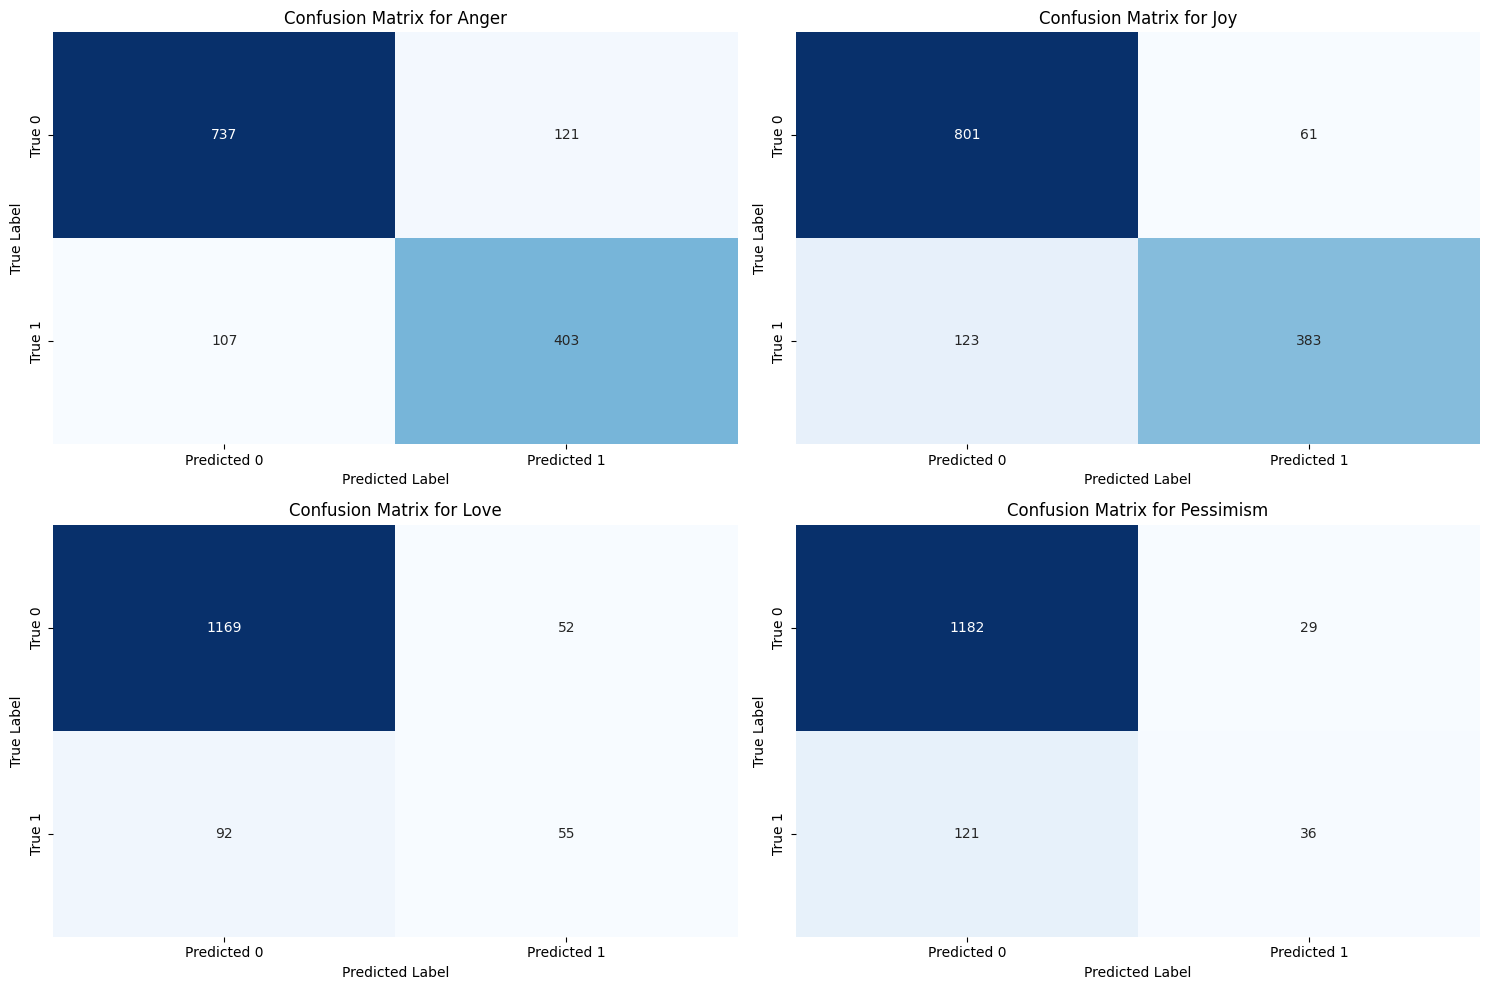

Confusion matrices displayed.


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

print("Obtaining predictions from the monolingual model...")

# 1. Obtain predictions from the monolingual model on the validation dataset
predictions_output = trainer.predict(tokenized_val_dataset)

# 2. Extract the true labels and predicted logits
true_labels = predictions_output.label_ids
predicted_logits = predictions_output.predictions

# 3. Apply the sigmoid function to the predicted logits to convert them into probabilities
probabilities = 1 / (1 + np.exp(-predicted_logits))

# 4. Convert these probabilities into binary predictions (0 or 1) using a threshold of 0.5
binary_predictions = (probabilities > 0.5).astype(int)

print("Calculating and displaying confusion matrices for each emotion...")

# 5. For each emotion in the emotions list, calculate and display its confusion matrix
plt.figure(figsize=(15, 10))
for i, emotion in enumerate(emotions):
    # a. Extract the true labels and binary predictions corresponding to that specific emotion
    true_emotion_labels = true_labels[:, i]
    predicted_emotion_labels = binary_predictions[:, i]

    # b. Calculate the confusion matrix
    cm = confusion_matrix(true_emotion_labels, predicted_emotion_labels)

    # c. Display the confusion matrix
    plt.subplot(2, 2, i + 1) # Arrange in 2x2 grid since there are 4 emotions
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['True 0', 'True 1'])
    plt.title(f'Confusion Matrix for {emotion.capitalize()}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

plt.tight_layout()
plt.show()
print("Confusion matrices displayed.")

## Compute and Display Confusion Matrices for Multilingual Model


Obtaining predictions from the multilingual model...


Calculating and displaying confusion matrices for each emotion (multilingual model)...


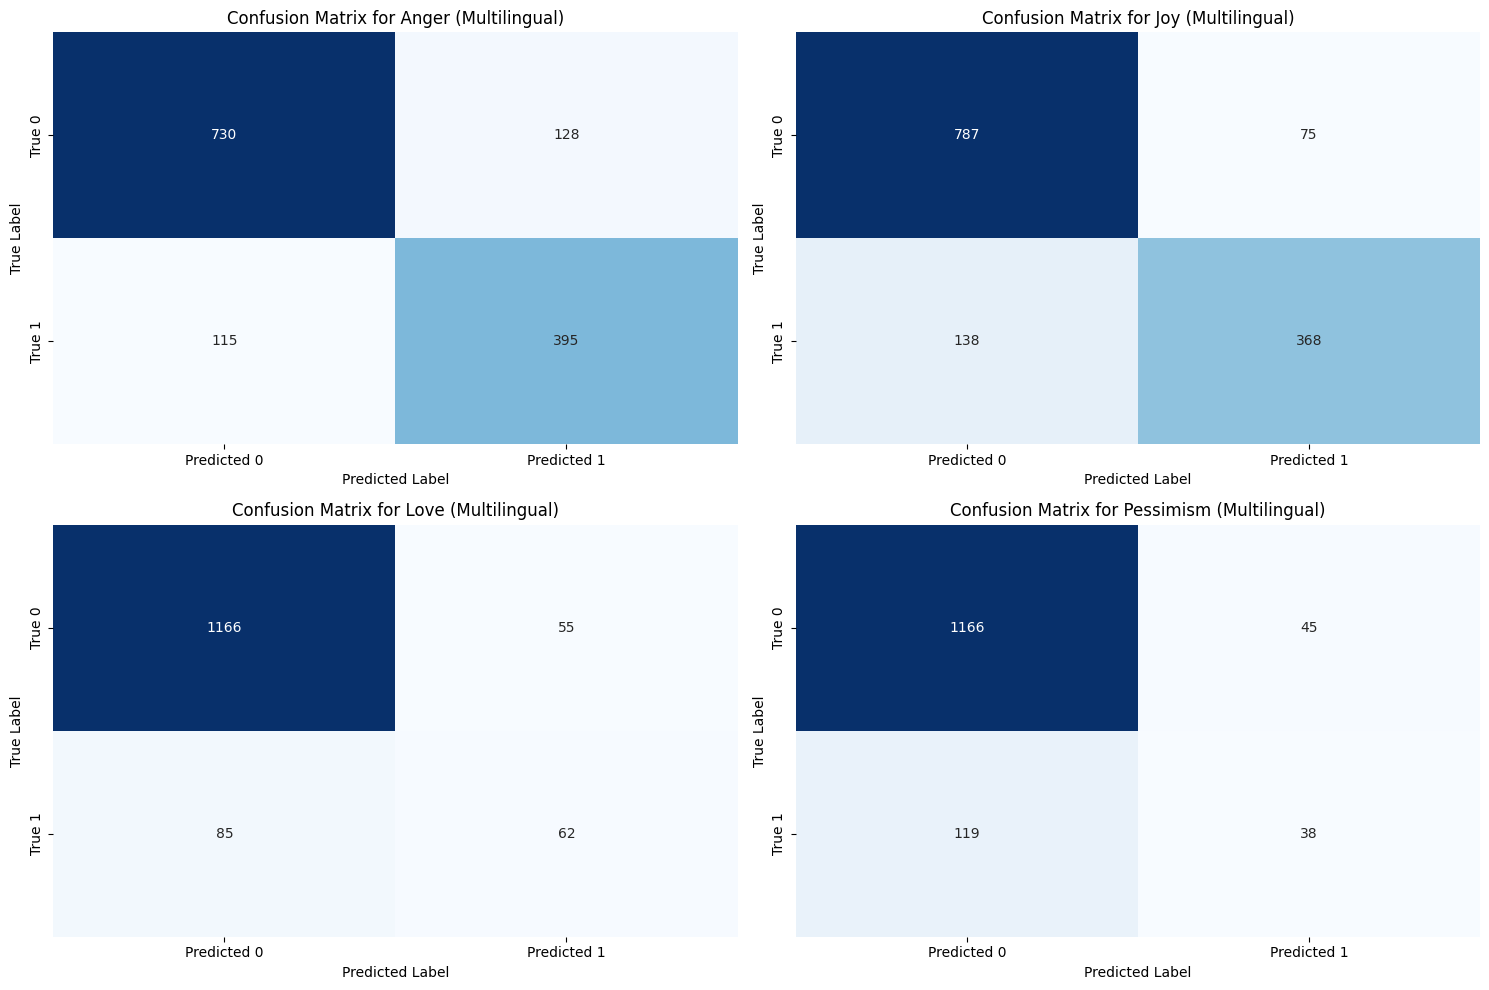

Confusion matrices for multilingual model displayed.


In [13]:
print("Obtaining predictions from the multilingual model...")

# 1. Obtain predictions from the multilingual model on the validation dataset
multilingual_predictions_output = multilingual_trainer.predict(tokenized_multilingual_val_dataset)

# 2. Extract the true labels and predicted logits
multilingual_true_labels = multilingual_predictions_output.label_ids
multilingual_predicted_logits = multilingual_predictions_output.predictions

# 3. Apply the sigmoid function to the predicted logits to convert them into probabilities
multilingual_probabilities = 1 / (1 + np.exp(-multilingual_predicted_logits))

# 4. Convert these probabilities into binary predictions (0 or 1) using a threshold of 0.5
multilingual_binary_predictions = (multilingual_probabilities > 0.5).astype(int)

print("Calculating and displaying confusion matrices for each emotion (multilingual model)...")

# 5. For each emotion in the emotions list, calculate and display its confusion matrix
plt.figure(figsize=(15, 10))
for i, emotion in enumerate(emotions):
    # a. Extract the true labels and binary predictions corresponding to that specific emotion
    true_emotion_labels = multilingual_true_labels[:, i]
    predicted_emotion_labels = multilingual_binary_predictions[:, i]

    # b. Calculate the confusion matrix
    cm = confusion_matrix(true_emotion_labels, predicted_emotion_labels)

    # c. Display the confusion matrix
    plt.subplot(2, 2, i + 1) # Arrange in 2x2 grid since there are 4 emotions
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['True 0', 'True 1'])
    plt.title(f'Confusion Matrix for {emotion.capitalize()} (Multilingual)')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

plt.tight_layout()
plt.show()
print("Confusion matrices for multilingual model displayed.")

## Calculating accuracy and F1-score for each emotion for both monolingual and multilingual models



In [16]:
print("Calculating performance metrics for monolingual and multilingual models...")

# Initialize lists to store metrics
monolingual_metrics_data = []
multilingual_metrics_data = []

# Iterate through each emotion
for i, emotion in enumerate(emotions):
    # Monolingual Model Metrics
    true_emotion_labels_mono = true_labels[:, i]
    predicted_emotion_labels_mono = binary_predictions[:, i]

    accuracy_mono = metrics.accuracy_score(true_emotion_labels_mono, predicted_emotion_labels_mono)
    f1_mono = metrics.f1_score(true_emotion_labels_mono, predicted_emotion_labels_mono, zero_division=0)

    monolingual_metrics_data.append({
        'Emotion': emotion,
        'Accuracy': accuracy_mono,
        'F1-Score': f1_mono
    })

    # Multilingual Model Metrics
    true_emotion_labels_multi = multilingual_true_labels[:, i]
    predicted_emotion_labels_multi = multilingual_binary_predictions[:, i]

    accuracy_multi = metrics.accuracy_score(true_emotion_labels_multi, predicted_emotion_labels_multi)
    f1_multi = metrics.f1_score(true_emotion_labels_multi, predicted_emotion_labels_multi, zero_division=0)

    multilingual_metrics_data.append({
        'Emotion': emotion,
        'Accuracy': accuracy_multi,
        'F1-Score': f1_multi
    })

# Create Pandas DataFrames
monolingual_metrics_df = pd.DataFrame(monolingual_metrics_data)
multilingual_metrics_df = pd.DataFrame(multilingual_metrics_data)

print("\nMonolingual Model Metrics:")
print(monolingual_metrics_df)

print("\nMultilingual Model Metrics:")
print(multilingual_metrics_df)

print("Performance metrics calculated and displayed.")

Calculating performance metrics for monolingual and multilingual models...

Monolingual Model Metrics:
     Emotion  Accuracy  F1-Score
0      anger  0.833333  0.779497
1        joy  0.865497  0.806316
2       love  0.894737  0.433071
3  pessimism  0.890351  0.324324

Multilingual Model Metrics:
     Emotion  Accuracy  F1-Score
0      anger  0.822368  0.764763
1        joy  0.844298  0.775553
2       love  0.897661  0.469697
3  pessimism  0.880117  0.316667
Performance metrics calculated and displayed.


## Visualize Performance Metrics



Imported matplotlib.pyplot as plt, seaborn as sns, and pandas as pd.
Concatenated monolingual and multilingual metrics into combined_metrics_df.
Melted combined_metrics_df into long format.


<Figure size 1400x700 with 0 Axes>

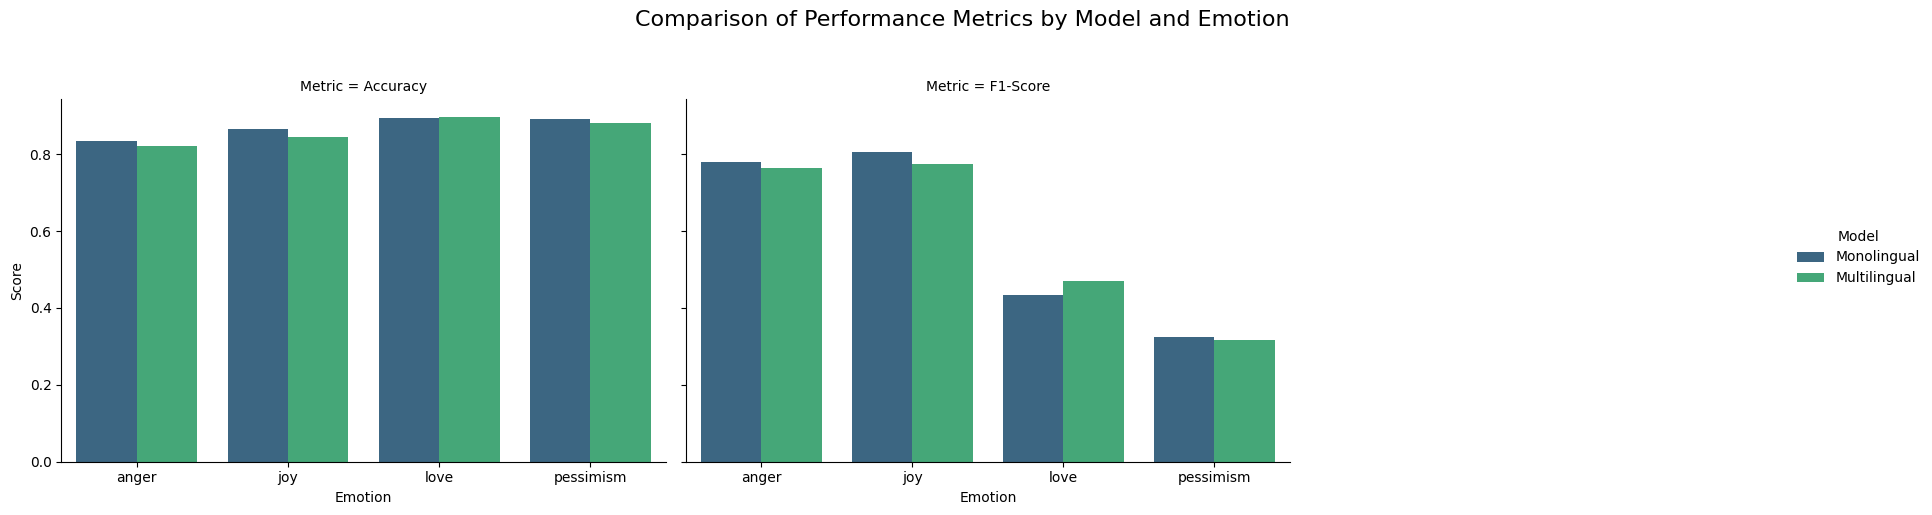

Grouped bar plot displayed.


In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd # Ensure pandas is imported as it's needed for DataFrame operations

print("Imported matplotlib.pyplot as plt, seaborn as sns, and pandas as pd.")

# 2. Add a 'Model' column to each DataFrame
monolingual_metrics_df['Model'] = 'Monolingual'
multilingual_metrics_df['Model'] = 'Multilingual'

# 3. Concatenate monolingual_metrics_df and multilingual_metrics_df
combined_metrics_df = pd.concat([monolingual_metrics_df, multilingual_metrics_df])
print("Concatenated monolingual and multilingual metrics into combined_metrics_df.")

# 4. Melt the combined_metrics_df
melted_metrics_df = combined_metrics_df.melt(id_vars=['Emotion', 'Model'],
                                             var_name='Metric',
                                             value_name='Score',
                                             value_vars=['Accuracy', 'F1-Score'])
print("Melted combined_metrics_df into long format.")

# 5. Create a grouped bar plot
plt.figure(figsize=(14, 7))
sns.catplot(data=melted_metrics_df,
            x='Emotion',
            y='Score',
            hue='Model',
            col='Metric',
            kind='bar',
            col_wrap=3, # Display metrics in a row
            height=5, aspect=1.2, palette='viridis')

# 6. Set the plot title
plt.suptitle('Comparison of Performance Metrics by Model and Emotion', y=1.02, fontsize=16)

# 7. Label the x-axis and y-axis (catplot automatically handles individual subplot labels, so we'll adjust the suptitle position)
# x-axis label is 'Emotion' handled by catplot
# y-axis label is 'Score' handled by catplot

# 8. Add a legend (handled by catplot's hue argument)

# 9. Display the plot
plt.tight_layout(rect=[0, 0, 1, 0.98]) # Adjust layout to prevent suptitle overlap
plt.show()
print("Grouped bar plot displayed.")

### Data Analysis Key Findings
*   The Monolingual model ($distilbert-base-uncased$) achieved higher F1-scores for 'anger' (approximately 0.779) and 'joy' (approximately 0.806), outperforming the Multilingual model for these emotions.
*   The Multilingual model ($bert-base-multilingual-cased$) showed a marginal advantage in detecting 'love', with an F1-score of approximately 0.470, compared to the Monolingual model's F1-score of about 0.433 for the same emotion.
*   Both models exhibited significantly weaker performance for 'pessimism', with the Monolingual model achieving an F1-score of about 0.324 and the Multilingual model an F1-score of approximately 0.317. This indicates a shared difficulty in classifying this specific emotion.
*   The Monolingual model demonstrated strong performance for more prevalent or distinctly expressed emotions like 'anger' and 'joy' in the English dataset, but struggled with more nuanced or less frequent emotions.
*   The Multilingual model was competitive for 'anger' and 'joy' but generally lagged behind the Monolingual model for these primary emotions.


In [18]:
!pip install --upgrade gradio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.0/23.0 MB 65.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.7/55.7 kB 5.3 MB/s eta 0:00:00
  Attempting uninstall: gradio-client
    Found existing installation: gradio_client 1.14.0
    Uninstalling gradio_client-1.14.0:
      Successfully uninstalled gradio_client-1.14.0
  Attempting uninstall: gradio
    Found existing installation: gradio 5.50.0
    Uninstalling gradio-5.50.0:
      Successfully uninstalled gradio-5.50.0


In [30]:
import gradio as gr
import torch

def predict_for_gradio(text):
    if not text:
        return "Please enter some text to analyze."

    # 1. Tokenize the text using the multilingual tokenizer
    inputs = multilingual_tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(multilingual_model.device)

    # 2. Get predictions from the multilingual model
    with torch.no_grad():
        logits = multilingual_model(**inputs).logits

    # 3. Convert to percentages (Sigmoid)
    probs = torch.sigmoid(logits).cpu().numpy()[0]

    # 4. Format results above a certain threshold (e.g., 30%)
    output_lines = [f"Tweet: '{text}'", "Detected Mental States:"]
    found = False
    for idx, score in enumerate(probs):
        if score > 0.3: # Threshold
            output_lines.append(f"   - {emotions[idx].capitalize()}: {score:.1%}")
            found = True

    if not found:
        output_lines.append("   - (Neutral / No strong emotion detected)")

    return "\n".join(output_lines)

# Custom CSS for a more visually appealing interface
custom_css = """
/* --- Main Fonts & Background --- */
@import url('https://fonts.googleapis.com/css2?family=Open+Sans:wght@400;600;700&display=swap');

.gradio-container {
    font-family: 'Open Sans', sans-serif !important;
    background: linear-gradient(135deg, #FFF0F5 0%, #FFB6C1 50%, #FF69B4 100%);
    background-image: radial-gradient(#ffffff 20%, transparent 20%),
                      linear-gradient(135deg, #FFF0F5 0%, #FFB6C1 50%, #FF69B4 100%);
    background-size: 20px 20px, 100% 100%;
}

/* --- The Main Glass Interface Box --- */
.gr-interface {
    max-width: 900px;
    margin: 30px auto;
    background: rgba(255, 255, 255, 0.5);
    backdrop-filter: blur(15px);
    -webkit-backdrop-filter: blur(15px);
    border: 2px solid rgba(255, 255, 255, 0.7);
    box-shadow: 0 8px 32px 0 rgba(255, 20, 147, 0.3);
    border-radius: 20px;
    overflow: hidden;
}

/* --- Header Area --- */
.gradio-header {
    background: linear-gradient(90deg, #FF1493 0%, #FF69B4 100%);
    color: white;
    padding: 25px;
    text-align: center;
    font-size: 2.2em;
    font-weight: bold;
    text-shadow: 1px 1px 3px rgba(0,0,0,0.2);
    border-bottom: none;
}

.gradio-description {
    font-size: 1.2em;
    color: #C71585;
    padding: 15px 20px;
    text-align: center;
    background-color: rgba(255, 182, 193, 0.4);
    border-bottom: 1px solid rgba(255, 255, 255, 0.5);
}

/* --- Inputs and Labels --- */
.gr-form label span, .gr-textbox label span {
    font-size: 1.1em;
    color: #D81B60 !important;
    font-weight: bold;
    font-family: 'Open Sans', sans-serif !important;
    background-color: transparent !important; /* Fixes label overlap background */
}

/* Styling input boxes */
.gr-box, .gr-input {
    border-color: #FFB6C1 !important;
    border-radius: 8px !important;
    background-color: rgba(255, 255, 255, 0.8) !important; /* Makes input slightly lighter */
}
.gr-box:focus-within, .gr-input:focus {
     border-color: #FF1493 !important;
     box-shadow: 0 0 8px rgba(255, 20, 147, 0.4) !important;
}

/* --- Buttons --- */
.gr-button {
    background-color: #E0218A !important;
    background-image: linear-gradient(to bottom right, #E0218A, #FF69B4) !important;
    color: white !important;
    border-radius: 30px !important;
    border: none !important;
    font-size: 1.2em !important;
    padding: 12px 30px !important;
    font-weight: bold !important;
    font-family: 'Open Sans', sans-serif !important;
    transition: transform 0.2s ease, box-shadow 0.2s ease !important;
    box-shadow: 0 4px 15px rgba(224, 33, 138, 0.4) !important;
}
.gr-button:hover {
    background-image: linear-gradient(to bottom right, #FF69B4, #FFB6C1) !important;
    transform: translateY(-2px);
    box-shadow: 0 6px 20px rgba(224, 33, 138, 0.6) !important;
}

/* --- FIX: Output Box Internals --- */
/* 1. The Container */
.output-class {
    background-color: #ffffff !important;
    border: 2px solid #FFB6C1 !important; /* Added a cute border back */
    border-radius: 12px;
    padding: 20px;
}

/* 2. The Internal Text Area (The BS part) */
.output-class textarea,
.output-class input,
.output-class .gr-box {
    background-color: transparent !important; /* Removes the dark grey bar */
    color: #C71585 !important; /* Makes the text pink */
    font-family: 'Consolas', 'Courier New', monospace;
    font-size: 1.05em;
    border: none !important; /* Removes internal borders */
    box-shadow: none !important; /* Removes internal shadows */
}
"""
# Create the Gradio interface with custom CSS
demo = gr.Interface(
    fn=predict_for_gradio,
    inputs=gr.Textbox(lines=5, placeholder="Enter text here...", label="Your Text"),
    outputs=gr.Textbox(label="Detected Emotions", elem_classes="output-class"),
    title="<h1 class='gradio-header'>Multilingual Emotion Detection</h1>",
    description="<p class='gradio-description'>Enter a tweet or text in various languages to detect emotions like anger, joy, love, and pessimism.</p>",
    css=custom_css
)

demo.launch(share=True)


/usr/local/lib/python3.12/dist-packages/gradio/interface.py:171: UserWarning: The parameters have been moved from the Blocks constructor to the launch() method in Gradio 6.0: css. Please pass these parameters to launch() instead.
  super().__init__(


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://c62fdf234ae808ccd8.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
